In [1]:
!pip install segmentation_models_pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 37.5 MB/s eta 0:00:00a 0:00:01
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=e99396a675cffbced026a425cb307a8c1e8cfe573a5c0e3b2fe6d23e6aad6454
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=8cb8327b0fc0d069f2619e4710a7776109cbd1985ec003b44f2a168f07a28d40
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels
  Attempting uninstall: timm
    Found existing in

In [2]:
!pip install lightning==2.0.9.post0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 20.8 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 853.1/853.1 kB 51.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 83.6 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: botocore
    Found existing installation: botocore 1.31.17
    Uninstalling botocore-1.31.17:
      Successfully uninstalled botocore-1.31.17
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
aiobotocore 2.5.4 requires botocore<1.31.18,>=1.31.17, but you have botocore 1.29.165 which is incompatible.


In [3]:
import os
from glob import glob 
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import torchvision
import cv2
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from tqdm import tqdm
import torchmetrics
import segmentation_models_pytorch as smp
import lightning.pytorch as pl
import torch.nn.functional as F
from torchinfo import summary
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
from lightning.pytorch.loggers import WandbLogger
import wandb
from sklearn.model_selection import train_test_split

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
import focal_loss_utils

In [5]:
# import wandb
# wandb.login()
# api = wandb.Api()
# run_name = "deeplabv3plus_landcoverai_resnet34_focal_nwc_v1"
# project_name = "deeplabv3plus_landcoverai_resnet34_focal_nwc_v1"
# runs = api.runs(project_name)
# run = [r for r in runs if r.name == run_name][0]
# f = run.file('deeplabv3plus_landcoverai_resnet34_focal_nwc_0_10_v1_resumed_checkpoint.ckpt')
# f.download()

In [6]:
def read_txt_file(path):
    file_name_list = []
    
    with open(path, 'r') as file:
        # Read each line (filename) from the file and append it to the list
        file_name_list = [line.strip() for line in file]
        
    return file_name_list

In [7]:
train_file_names = read_txt_file("/kaggle/input/landcover-ai-patches/train.txt")[:8680]

In [8]:
len(train_file_names)

8680

In [9]:
test_file_names = read_txt_file("/kaggle/input/landcover-ai-patches/test.txt")[:1600]

In [10]:
len(test_file_names)

1600

In [11]:
val_file_names = read_txt_file("/kaggle/input/landcover-ai-patches/val.txt")[:1600]

In [12]:
len(val_file_names)

1600

# id2label

In [13]:
id2label = {
    0:"Background",
    1:"Building",
    2:"Woodland",
    3:"Water",
    4:"Road",
}

# Dataset

In [14]:
class LandCoverDataset(Dataset):
    
    def __init__(self, file_names, transform=None):
        self.img_path = '/kaggle/input/landcover-ai-patches/images/'
        self.mask_path = '/kaggle/input/landcover-ai-patches/masks/'
        self.file_names = file_names
        
        self.mean = [0.385, 0.409, 0.355]
        self.std = [0.172, 0.144, 0.123]
        
        # Albumentation Transform are used
        self.transform = transform
        
        
    def __len__(self):
        return len(self.file_names)
    
    def __getitem__(self, index):
        
        img = np.array(Image.open(f'{self.img_path}{self.file_names[index]}.jpg'))
        mask = cv2.imread(f'{self.mask_path}{self.file_names[index]}.png', cv2.IMREAD_GRAYSCALE)
        
        original_img = img
        original_mask = mask
        
        # Apply transform if there are transform
        if self.transform is not None:
            augmented_img_mask = self.transform(image=img, mask=mask)
            img = augmented_img_mask['image']
            mask = augmented_img_mask['mask']
            
            
        
        mask = torch.from_numpy(mask).long()
        
        # Normalize and convert to tensor
        final_transform = A.Compose([
                A.Normalize(mean=self.mean, std=self.std),
                ToTensorV2()
            ])

        img = final_transform(image=img)
        img = img['image']
        
        return img, mask, original_img, original_mask

In [15]:
train_transforms = A.Compose([
    A.HorizontalFlip(p=0.3),
    A.VerticalFlip(p=0.3),
    A.Rotate(limit=(-15,15),p=0.3)
])

In [16]:
train_ds = LandCoverDataset(train_file_names, transform=train_transforms)
val_ds = LandCoverDataset(val_file_names)
test_ds = LandCoverDataset(test_file_names)

In [17]:
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

8680
1600
1600


# Data Loader

In [18]:
train_loader = DataLoader(train_ds, batch_size=8,num_workers=2,shuffle=True)
val_loader = DataLoader(val_ds, batch_size=8,num_workers=2)
test_loader = DataLoader(test_ds, batch_size=8,num_workers=2)

# DeepLabV3+

https://github.com/Lightning-AI/torchmetrics/issues/1425

In [19]:
class DeepLabV3Plus_pl(pl.LightningModule):
    def __init__(self, n_classes, lr=1e-4, encoder_name="resnet50", encoder_weights="imagenet"):
        super().__init__()
        self.n_classes = n_classes

        
        self.model = smp.DeepLabV3Plus(encoder_name=encoder_name,encoder_weights=encoder_weights,classes=n_classes)
        self.lr = lr
        self.save_hyperparameters('n_classes','encoder_name','encoder_weights','lr')
        
        self.accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=n_classes, average='macro')
        self.accuracy_class = torchmetrics.Accuracy(task="multiclass", num_classes=n_classes, average=None)
        self.precision = torchmetrics.Precision(task="multiclass", num_classes=n_classes, average='macro')
        self.precision_class = torchmetrics.Precision(task="multiclass", num_classes=n_classes, average=None)
        self.recall = torchmetrics.Recall(task="multiclass", num_classes=n_classes, average='macro')
        self.recall_class = torchmetrics.Recall(task="multiclass", num_classes=n_classes, average=None)
        self.f1 = torchmetrics.F1Score(task="multiclass", num_classes=n_classes, average='macro')
        self.f1_class = torchmetrics.F1Score(task="multiclass", num_classes=n_classes, average=None)
        self.jaccard = torchmetrics.JaccardIndex(task="multiclass", num_classes=n_classes, average='macro')
        self.jaccard_class = torchmetrics.JaccardIndex(task="multiclass", num_classes=n_classes,average=None)
        self.dice = torchmetrics.Dice(num_classes=n_classes, average='macro')
#         self.dice_class = torchmetrics.Dice(num_classes=n_classes, average=None)
        
        # Class Weights
        self.class_weights = [0.00868963, 0.58788445, 0.01520088, 0.07803337, 0.31019167]
        self.class_weights_unnorm = torch.tensor([1.7258057494713657, 116.75693945538318, 3.018974415508092, 15.497838011613178, 61.60569406906407], dtype=torch.float32)
        
        self.loss = smp.losses.JaccardLoss(mode='multiclass')
#         self.loss = smp.losses.DiceLoss(mode='multiclass')
#         self.loss = smp.losses.FocalLoss(mode='multiclass', gamma=2.0)
        
#         self.loss = focal_loss_utils.WFocalLoss(mode='multiclass', gamma=2.0, alpha=self.class_weights)
#         self.loss = torch.hub.load(
#             'adeelh/pytorch-multi-class-focal-loss',
#             model='FocalLoss',
#             alpha=torch.tensor(self.class_weights),
#             gamma=2,
#             reduction='mean',
#         )
        
#         self.loss = nn.CrossEntropyLoss()
        
#         self.loss = nn.CrossEntropyLoss(weight=self.class_weights_unnorm)
        
        self.id2label = {
            0:"Background",
            1:"Building",
            2:"Woodland",
            3:"Water",
            4:"Road",
        }

    def forward(self, x):
        logits = self.model(x)
        return logits
    
    def training_step(self, batch, batch_idx):
        x, y, _, _ = batch
        y_hat = self(x)
        
        y_hat_argmax = torch.argmax(torch.softmax(y_hat,dim=1),dim=1)
        loss = self.loss(y_hat, y)
        
        # Torch metric
        tm_acc = self.accuracy(y_hat_argmax,y)
        tm_rec = self.recall(y_hat_argmax,y)
        tm_prec = self.precision(y_hat_argmax,y)
        tm_iou = self.jaccard(y_hat_argmax,y)
        tm_f1 = self.f1(y_hat_argmax,y)
        tm_dice = self.dice(y_hat_argmax,y)
        
        
        self.log_dict({
            "train_loss":loss,
            "train_acc":tm_acc,
            "train_iou":tm_iou,
            "train_f1":tm_f1,
            "train_precision":tm_prec,
            "train_recall":tm_rec,
            "train_dice":tm_dice,
        },prog_bar=True, on_step=True, on_epoch=True)
        
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y, _, _ = batch
        y_hat = self(x)
        
        
        y_hat_argmax = torch.argmax(torch.softmax(y_hat,dim=1),dim=1)
        loss = self.loss(y_hat, y)
        
        # Torch metric
        tm_acc = self.accuracy(y_hat_argmax,y)
        tm_acc_class = self.accuracy_class(y_hat_argmax,y)
        tm_rec = self.recall(y_hat_argmax,y)
        tm_rec_class = self.recall_class(y_hat_argmax,y)
        tm_prec = self.precision(y_hat_argmax,y)
        tm_prec_class = self.precision_class(y_hat_argmax,y)
        tm_iou = self.jaccard(y_hat_argmax,y)
        tm_iou_class = self.jaccard_class(y_hat_argmax,y) 
        tm_f1 = self.f1(y_hat_argmax,y)
        tm_f1_class = self.f1_class(y_hat_argmax,y)
        tm_dice = self.dice(y_hat_argmax,y)
#         tm_dice_class = self.dice_class(y_hat_argmax,y)
        
        log_dict = {
            "val_loss":loss,
            "val_acc":tm_acc,
            "val_iou":tm_iou,
            "val_f1":tm_f1,
            "val_precision":tm_prec,
            "val_recall":tm_rec,
            "val_dice":tm_dice
        }
        
        for i, x in enumerate(tm_acc_class):
            log_dict[f'val_acc_class_{self.id2label[i]}'] = x
        
        for i, x in enumerate(tm_iou_class):
            log_dict[f'val_iou_class_{self.id2label[i]}'] = x
            
        for i, x in enumerate(tm_f1_class):
            log_dict[f'val_f1_class_{self.id2label[i]}'] = x
            
        for i, x in enumerate(tm_prec_class):
            log_dict[f'val_precision_class_{self.id2label[i]}'] = x
            
        for i, x in enumerate(tm_rec_class):
            log_dict[f'val_recall_class_{self.id2label[i]}'] = x
            
#         for i, x in enumerate(tm_dice_class):
#             log_dict[f'val_dice_class_{self.id2label[i]}'] = x
        
        self.log_dict(
            log_dict
        ,prog_bar=True, on_step=False, on_epoch=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

In [20]:
model = DeepLabV3Plus_pl(n_classes=5,encoder_name="resnet34")

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 75.9MB/s]


In [21]:
model.lr

0.0001

In [22]:
# out = model(im.unsqueeze(0))

In [23]:
# pred = torch.argmax(torch.softmax(out,dim=1),dim=1)

In [24]:
# plt.imshow(pred.squeeze(0))

# Model Summary

In [25]:
summary(model)

Layer (type:depth-idx)                                       Param #
DeepLabV3Plus_pl                                             --
├─DeepLabV3Plus: 1-1                                         --
│    └─ResNetEncoder: 2-1                                    --
│    │    └─Conv2d: 3-1                                      9,408
│    │    └─BatchNorm2d: 3-2                                 128
│    │    └─ReLU: 3-3                                        --
│    │    └─MaxPool2d: 3-4                                   --
│    │    └─Sequential: 3-5                                  221,952
│    │    └─Sequential: 3-6                                  1,116,416
│    │    └─Sequential: 3-7                                  6,822,400
│    │    └─Sequential: 3-8                                  13,114,368
│    └─DeepLabV3PlusDecoder: 2-2                             --
│    │    └─Sequential: 3-9                                  1,068,288
│    │    └─UpsamplingBilinear2d: 3-10                       

# LR Finder (Optional)

In [26]:
# lr_trainer = pl.Trainer()
# tuner = pl.tuner.Tuner(lr_trainer)

In [27]:
# lr_finder = tuner.lr_find(
#     model, 
#     train_dataloaders=train_loader,
# )

In [28]:
# fig = lr_finder.plot(suggest=True)
# fig.show()

In [29]:
model.lr

0.0001

In [30]:
model.lr = 0.0005

In [31]:
model.lr

0.0005

# Logger

In [32]:
# add id param to resume training
# deeplabv3plus_landcoverai_resnet34_v1
# wandb_logger = WandbLogger(name="test_resume",project="test_resume", id='x8wlq9tv')
wandb_logger = WandbLogger(name="deeplabv3plus_landcoverai_resnet34_iou_v1",project="skripsi_landcoverai_augment")

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [33]:
wandb.run.id

'xl525zso'

# Trainer

In [34]:
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    filename='deeplabv3plus_landcoverai_resnet34_iou_v1'
)

In [35]:
trainer = pl.Trainer(
    fast_dev_run=False,
    max_epochs=10,
    callbacks=[EarlyStopping(monitor="val_loss",patience=5),checkpoint_callback],
    logger=wandb_logger,
    log_every_n_steps=10
)

INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs


# Resume Training (Uncomment to resmue from checkpoint)

In [36]:
# model = DeepLabV3Plus_pl(n_classes=5,encoder_name="resnet34").load_from_checkpoint('PATH')

In [37]:
# trainer.fit(model, train_loader, val_loader, ckpt_path="/kaggle/working/test3_deeplabv3plus_landcoverai_0_10_resnet34_v1_checkpoint.ckpt")

# Training

In [38]:
trainer.fit(model,train_loader,val_loader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
   | Name            | Type                   | Params
------------------------------------------------------------
0  | model           | DeepLabV3Plus          | 22.4 M
1  | accuracy        | MulticlassAccuracy     | 0     
2  | accuracy_class  | MulticlassAccuracy     | 0     
3  | precision       | MulticlassPrecision    | 0     
4  | precision_class | MulticlassPrecision    | 0     
5  | recall          | MulticlassRecall       | 0     
6  | recall_class    | MulticlassRecall       | 0     
7  | f1              | MulticlassF1Score      | 0     
8  | f1_class        | MulticlassF1Score      | 0     
9  | jaccard         | MulticlassJaccardIndex | 0     
10 | jaccard_class   | MulticlassJaccardIndex | 0     
11 | dice            | Dice                   | 0     
12 | loss            | JaccardLoss            | 0     
------------------------------------------------------------
22.4 M    Trainable params
0         Non-trainable pa

Sanity Checking: 0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/opt/conda/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.


# Validate

In [39]:
trainer.validate(model,val_loader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Validate metric         ┃          DataLoader 0          ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│            val_acc             │       0.697415292263031        │
│    val_acc_class_Background    │       0.9166739583015442       │
│     val_acc_class_Building     │       0.414936900138855        │
│       val_acc_class_Road       │       0.5722349286079407       │
│      val_acc_class_Water       │       0.3736606240272522       │
│     val_acc_class_Woodland     │       0.8107658624649048       │
│            val_dice            │       0.6930424571037292       │
│             val_f1             │       0.6930424571037292       │
│    val_f1_class_Background     │       0.9168617129325867       │
│     val_f1_class_Building      │      0.37415003776550293       │
│       val_f1_class_Road        │       0.5795427560806274       │
│       val_f1_class_Water       │      0.37896397709846497       │
│     val_f1_class_Woodland      │       0.8204209208488464       │
│            val_iou             │       0.6098667979240417       │
│    val_iou_class_Background    │       0.857103168964386        │
│     val_iou_class_Building     │       0.3089083731174469       │
│       val_iou_class_Road       │       0.4547501504421234       │
│      val_iou_class_Water       │       0.3405403196811676       │
│     val_iou_class_Woodland     │       0.7357518076896667       │
│            val_loss            │       0.269599586725235        │
│         val_precision          │       0.7251330614089966       │
│ val_precision_class_Background │       0.9245133996009827       │
│  val_precision_class_Building  │      0.36214083433151245       │
│    val_precision_class_Road    │       0.6440263986587524       │
│   val_precision_class_Water    │       0.4141409695148468       │
│  val_precision_class_Woodland  │       0.8646687269210815       │
│           val_recall           │       0.697415292263031        │
│  val_recall_class_Background   │       0.9166739583015442       │
│   val_recall_class_Building    │       0.414936900138855        │
│     val_recall_class_Road      │       0.5722349286079407       │
│     val_recall_class_Water     │       0.3736606240272522       │
│   val_recall_class_Woodland    │       0.8107658624649048       │
└────────────────────────────────┴────────────────────────────────┘

[{'val_loss': 0.269599586725235,
  'val_acc': 0.697415292263031,
  'val_iou': 0.6098667979240417,
  'val_f1': 0.6930424571037292,
  'val_precision': 0.7251330614089966,
  'val_recall': 0.697415292263031,
  'val_dice': 0.6930424571037292,
  'val_acc_class_Background': 0.9166739583015442,
  'val_acc_class_Building': 0.414936900138855,
  'val_acc_class_Woodland': 0.8107658624649048,
  'val_acc_class_Water': 0.3736606240272522,
  'val_acc_class_Road': 0.5722349286079407,
  'val_iou_class_Background': 0.857103168964386,
  'val_iou_class_Building': 0.3089083731174469,
  'val_iou_class_Woodland': 0.7357518076896667,
  'val_iou_class_Water': 0.3405403196811676,
  'val_iou_class_Road': 0.4547501504421234,
  'val_f1_class_Background': 0.9168617129325867,
  'val_f1_class_Building': 0.37415003776550293,
  'val_f1_class_Woodland': 0.8204209208488464,
  'val_f1_class_Water': 0.37896397709846497,
  'val_f1_class_Road': 0.5795427560806274,
  'val_precision_class_Background': 0.9245133996009827,
  'val

In [40]:
trainer.validate(model,test_loader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Validate metric         ┃          DataLoader 0          ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│            val_acc             │       0.6791942119598389       │
│    val_acc_class_Background    │       0.8957873582839966       │
│     val_acc_class_Building     │      0.41107499599456787       │
│       val_acc_class_Road       │       0.5346875190734863       │
│      val_acc_class_Water       │      0.36450645327568054       │
│     val_acc_class_Woodland     │       0.8178582787513733       │
│            val_dice            │       0.6788763999938965       │
│             val_f1             │       0.6788763999938965       │
│    val_f1_class_Background     │       0.8995605707168579       │
│     val_f1_class_Building      │      0.36292561888694763       │
│       val_f1_class_Road        │       0.5525112748146057       │
│       val_f1_class_Water       │       0.3755912780761719       │
│     val_f1_class_Woodland      │       0.8279995918273926       │
│            val_iou             │       0.5975944399833679       │
│    val_iou_class_Background    │       0.8353535532951355       │
│     val_iou_class_Building     │       0.2984113097190857       │
│       val_iou_class_Road       │       0.4335445463657379       │
│      val_iou_class_Water       │      0.33665844798088074       │
│     val_iou_class_Woodland     │       0.7475811243057251       │
│            val_loss            │       0.2804144322872162       │
│         val_precision          │       0.7253519296646118       │
│ val_precision_class_Background │       0.9114127159118652       │
│  val_precision_class_Building  │      0.35278815031051636       │
│    val_precision_class_Road    │       0.6522036194801331       │
│   val_precision_class_Water    │      0.43941742181777954       │
│  val_precision_class_Woodland  │       0.8722236752510071       │
│           val_recall           │       0.6791942119598389       │
│  val_recall_class_Background   │       0.8957873582839966       │
│   val_recall_class_Building    │      0.41107499599456787       │
│     val_recall_class_Road      │       0.5346875190734863       │
│     val_recall_class_Water     │      0.36450645327568054       │
│   val_recall_class_Woodland    │       0.8178582787513733       │
└────────────────────────────────┴────────────────────────────────┘

[{'val_loss': 0.2804144322872162,
  'val_acc': 0.6791942119598389,
  'val_iou': 0.5975944399833679,
  'val_f1': 0.6788763999938965,
  'val_precision': 0.7253519296646118,
  'val_recall': 0.6791942119598389,
  'val_dice': 0.6788763999938965,
  'val_acc_class_Background': 0.8957873582839966,
  'val_acc_class_Building': 0.41107499599456787,
  'val_acc_class_Woodland': 0.8178582787513733,
  'val_acc_class_Water': 0.36450645327568054,
  'val_acc_class_Road': 0.5346875190734863,
  'val_iou_class_Background': 0.8353535532951355,
  'val_iou_class_Building': 0.2984113097190857,
  'val_iou_class_Woodland': 0.7475811243057251,
  'val_iou_class_Water': 0.33665844798088074,
  'val_iou_class_Road': 0.4335445463657379,
  'val_f1_class_Background': 0.8995605707168579,
  'val_f1_class_Building': 0.36292561888694763,
  'val_f1_class_Woodland': 0.8279995918273926,
  'val_f1_class_Water': 0.3755912780761719,
  'val_f1_class_Road': 0.5525112748146057,
  'val_precision_class_Background': 0.9114127159118652,

# Save

In [41]:
trainer.save_checkpoint("deeplabv3plus_landcoverai_resnet34_iou_0_10_v1_checkpoint.ckpt")

In [42]:
torch.save(model, "deeplabv3plus_landcoverai_resnet34_iou_0_10_v1.pth")

In [43]:
torch.save(model.state_dict(), "deeplabv3plus_landcoverai_resnet34_iou_0_10_v1_state_dict.pth")

In [44]:
wandb.save('/kaggle/working/deeplabv3plus_landcoverai_resnet34_iou_0_10_v1.pth')

wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


['./wandb/run-20231212_092720-xl525zso/files/deeplabv3plus_landcoverai_resnet34_iou_0_10_v1.pth']

In [45]:
wandb.save('/kaggle/working/deeplabv3plus_landcoverai_resnet34_iou_0_10_v1_state_dict.pth')

['./wandb/run-20231212_092720-xl525zso/files/deeplabv3plus_landcoverai_resnet34_iou_0_10_v1_state_dict.pth']

In [46]:
wandb.save('/kaggle/working/deeplabv3plus_landcoverai_resnet34_iou_0_10_v1_checkpoint.ckpt')

['./wandb/run-20231212_092720-xl525zso/files/deeplabv3plus_landcoverai_resnet34_iou_0_10_v1_checkpoint.ckpt']

In [47]:
wandb.save(checkpoint_callback.best_model_path)

['./wandb/run-20231212_092720-xl525zso/files/skripsi_landcoverai_augment/xl525zso/checkpoints/deeplabv3plus_landcoverai_resnet34_iou_v1.ckpt']

In [48]:
wandb.finish()

epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
train_acc_epoch,▁▄▅▆▆▇▇▇██
train_acc_step,▆▅▄▁▁▅▅▃▄▃▅▃▅▄▆▂▆▆▃▃▆▆▄█▆▄▇▂▆▃▇██▇▇▇▅▃▇▃
train_dice_epoch,▁▄▅▆▆▇▇▇██
train_dice_step,▄▂▅▁▂▅▆▄▄▂▄▂▄▄▇▃▆▇▄▃▇▅▃█▆▄▇▂▇▄██▇█▇▆▄▃▇▃
train_f1_epoch,▁▄▅▆▆▇▇▇██
train_f1_step,▄▂▅▁▂▅▆▄▄▂▄▂▄▄▇▃▆▇▄▃▇▅▃█▆▄▇▂▇▄██▇█▇▆▄▃▇▃
train_iou_epoch,▁▄▅▆▆▇▇▇██
train_iou_step,▄▂▅▁▂▄▅▄▃▂▃▁▄▄▇▃▅▇▄▃▇▅▄█▆▃▇▃▆▄▇█▇▇▇▅▄▄▇▄
train_loss_epoch,█▅▄▃▃▂▂▂▁▁
train_loss_step,▆▇▄█▇▅▄▅▆▇▆█▅▅▂▆▄▂▂▆▂▄▂▁▃▆▂▃▃▂▂▁▂▂▂▄▅▂▂▂


# Inference

In [49]:
im_t, ma_t, ori_im, ori_ma = test_ds[389]

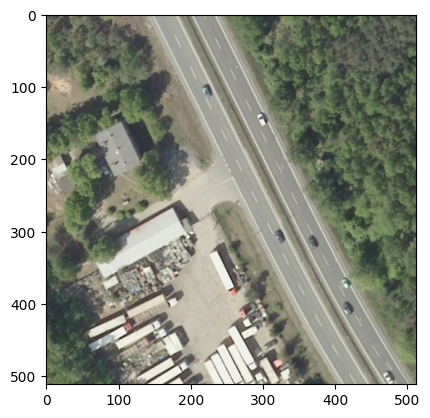

In [50]:
plt.imshow(ori_im)

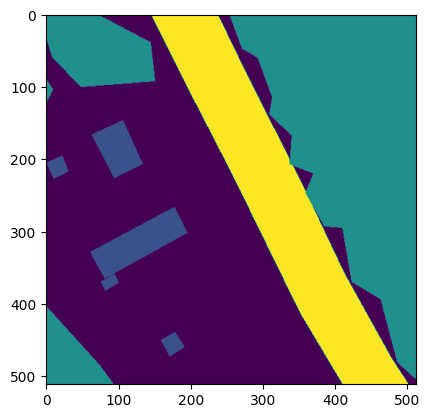

In [51]:
plt.imshow(ori_ma)

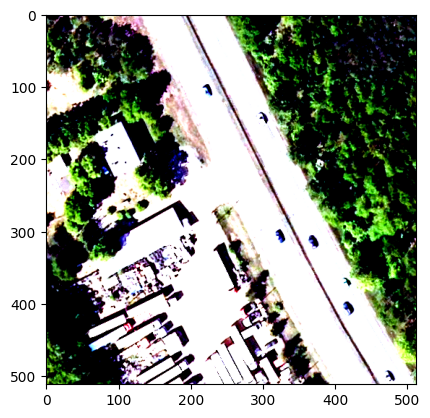

In [52]:
plt.imshow(im_t.permute(1,2,0))

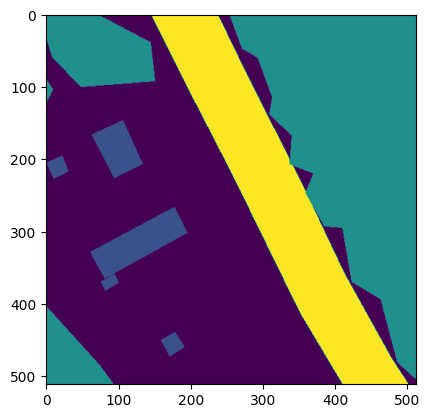

In [53]:
plt.imshow(ma_t)

In [54]:
model.eval()
out = model(im_t.unsqueeze(0))

In [55]:
pred = torch.argmax(torch.softmax(out,dim=1),dim=1)

In [56]:
pred.shape

torch.Size([1, 512, 512])

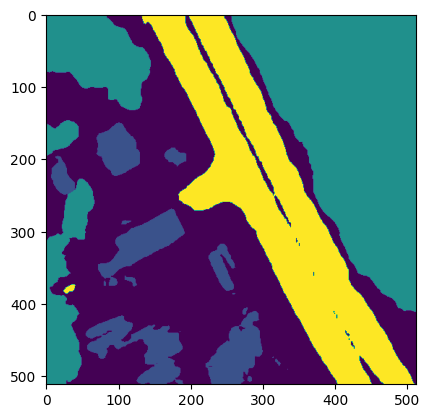

In [57]:
plt.imshow(pred.squeeze(0))